In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
# Parameters for tunning

BASE_IMG_FOLDER = './VC_2425_Project_public/images/'

# Parameters for the image processing
SHOW_DEBUG_IMGS = "LINES" # ["LINES", "WARP", "ALL", "NONE"]

In [3]:
def show_original_and_gray(image_path):
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    if (SHOW_DEBUG_IMGS == "ALL"):
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.title('Original RGB Image')

        plt.subplot(1, 2, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
        plt.title('Grayscale Image')
        plt.tight_layout()
        plt.show()

    return original_img, gray_img

In [4]:
def preprocess_image(gray_img, blur_kernel_size=17, intensity_factor=1.5, laplacian_kernel_size=3):
    blurred = cv2.GaussianBlur(gray_img, (blur_kernel_size, blur_kernel_size), 0)
    adjusted_img = cv2.convertScaleAbs(blurred, alpha=intensity_factor, beta=0)

    # Morphological opening to remove small details like pieces
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opened = cv2.morphologyEx(adjusted_img, cv2.MORPH_OPEN, kernel)

    laplacian = cv2.Laplacian(opened, cv2.CV_64F, ksize=laplacian_kernel_size)
    laplacian = cv2.convertScaleAbs(laplacian)

    # OTSU + optional manual offset to suppress weak edges
    otsu_thresh_val, _ = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary_img = cv2.threshold(laplacian, otsu_thresh_val + 20, 255, cv2.THRESH_BINARY)

    if (SHOW_DEBUG_IMGS == "ALL"):
        plt.figure(figsize=(7, 7))
        plt.title("Binary after Opening + Laplacian + OTSU + Offset")
        plt.imshow(binary_img, cmap="gray")
        plt.axis('off')
        plt.show()

    return binary_img

In [5]:
def detect_lines(binary_img, min_line_length=50, max_line_gap=50):
    # Canny edge detection with lower threshold
    canny_image = cv2.Canny(binary_img, 50, 200)  # Tuning thresholds to capture better edges

    # Use dilation to reinforce edges
    kernel = np.ones((11, 11), np.uint8)
    dilation_image = cv2.dilate(canny_image, kernel, iterations=1)
    
    if (SHOW_DEBUG_IMGS == "ALL"):
        plt.figure(figsize=(15, 5))
        plt.title("Dilated Edges")
        plt.imshow(dilation_image, cmap="gray")
        plt.axis('off')
        plt.show()
    
    
    # Hough Lines transform for line detection
    lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Create an image to store the detected lines
    black_image = np.zeros_like(dilation_image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Apply final dilation to reinforce the lines detected
    final_kernel = np.ones((3, 3), np.uint8)
    black_image = cv2.dilate(black_image, final_kernel, iterations=1)

    


    return black_image

In [6]:
def remove_noise_components(line_img, min_area=1000, keep_largest=True):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(line_img, connectivity=8)
    
    # Create a black image to store the final result
    final_image = np.zeros_like(line_img)
    
    if keep_largest:
        # Get the areas of all components (ignoring the background)
        areas = stats[1:, cv2.CC_STAT_AREA]
        
        # Find the label of the largest component
        max_label = 1 + np.argmax(areas)
        
        # Keep only the largest component
        final_image[labels == max_label] = 255
    else:
        # If not keeping only the largest component, keep components above the min_area threshold
        for label in range(1, num_labels):
            area = stats[label, cv2.CC_STAT_AREA]
            if area >= min_area:
                final_image[labels == label] = 255

    if (SHOW_DEBUG_IMGS == "ALL" or SHOW_DEBUG_IMGS == "LINES"):
        plt.subplot(1, 2, 1)
        plt.title("Only Board Lines (Filtered)")
        plt.imshow(final_image, cmap="gray")
        plt.axis('off')

    return final_image


In [7]:
def find_chessboard_contour(line_img):
    contours, _ = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if contours:
        return contours[0]
    return None

In [8]:
def order_corners(corners):
    sorted_by_y = sorted(corners, key=lambda p: p[1])
    top_two = sorted(sorted_by_y[:2], key=lambda p: p[0])
    bottom_two = sorted(sorted_by_y[2:], key=lambda p: p[0])
    return np.array([top_two[0], top_two[1], bottom_two[0], bottom_two[1]], dtype="float32")

In [9]:
def warp_chessboard(gray_img, contour, board_size=800):
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx_corners = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx_corners) == 4:
        corners = np.squeeze(approx_corners)
        ordered_corners = order_corners(corners)
        dst_corners = np.array([
            [0, 0], [board_size - 1, 0],
            [0, board_size - 1], [board_size - 1, board_size - 1]
        ], dtype="float32")
        matrix = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
        warped_board = cv2.warpPerspective(gray_img, matrix, (board_size, board_size))

        if (SHOW_DEBUG_IMGS == "ALL" or SHOW_DEBUG_IMGS == "LINES"):
            plt.subplot(1, 2, 2)
            plt.title("Warped Chessboard")
            plt.imshow(warped_board, cmap="gray")
            plt.axis('off')

        return warped_board
    else:
        print("Error: Did not find exactly 4 corners!")
        return None

In [10]:
def process_chessboard_image(image_path):
    original_img, gray_img = show_original_and_gray(image_path)
    otsu_binary = preprocess_image(gray_img)
    line_img = detect_lines(otsu_binary)
    clean_line_img = remove_noise_components(line_img)
    contour = find_chessboard_contour(clean_line_img)
    if contour is not None:
        return warp_chessboard(gray_img, contour)
    else:
        print("Chessboard contour not found!")
        return None

Processing G000_IMG062.jpg


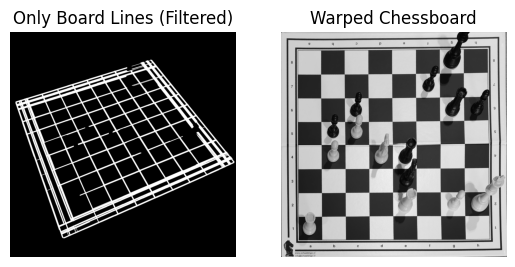

<Figure size 1500x700 with 0 Axes>

Processing G000_IMG087.jpg


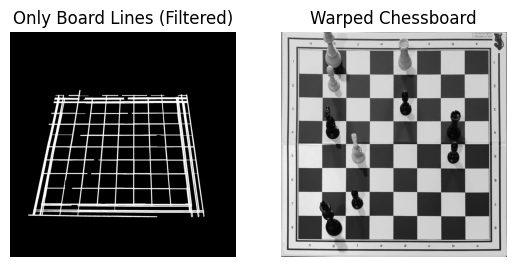

<Figure size 1500x700 with 0 Axes>

Processing G000_IMG102.jpg


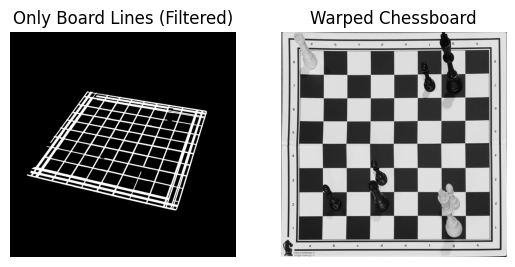

<Figure size 1500x700 with 0 Axes>

Processing G006_IMG048.jpg


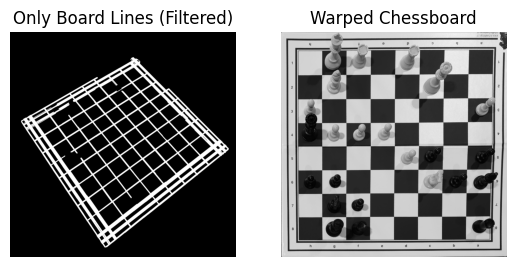

<Figure size 1500x700 with 0 Axes>

Processing G006_IMG086.jpg


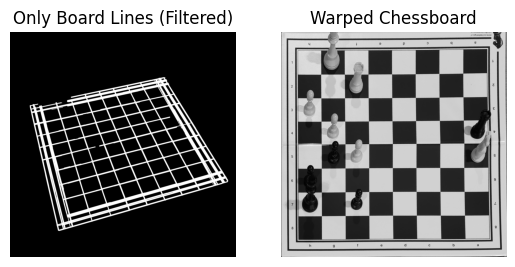

<Figure size 1500x700 with 0 Axes>

Processing G006_IMG119.jpg


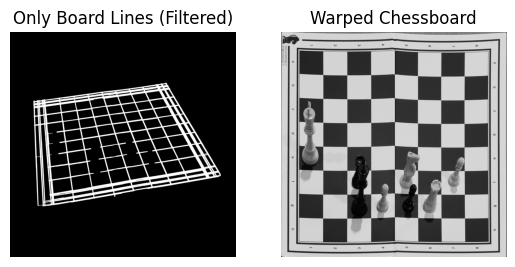

<Figure size 1500x700 with 0 Axes>

Processing G019_IMG082.jpg


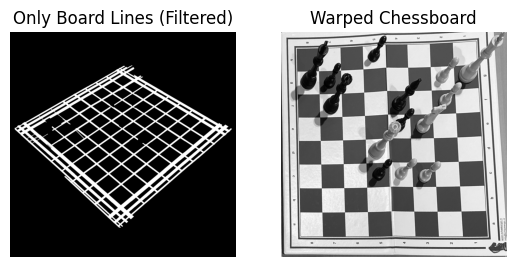

<Figure size 1500x700 with 0 Axes>

Processing G028_IMG015.jpg


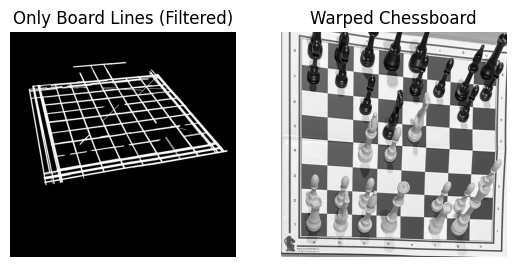

<Figure size 1500x700 with 0 Axes>

Processing G028_IMG062.jpg


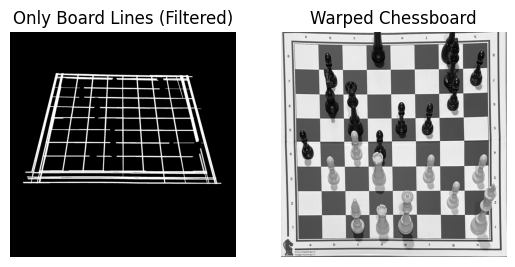

<Figure size 1500x700 with 0 Axes>

Processing G028_IMG098.jpg


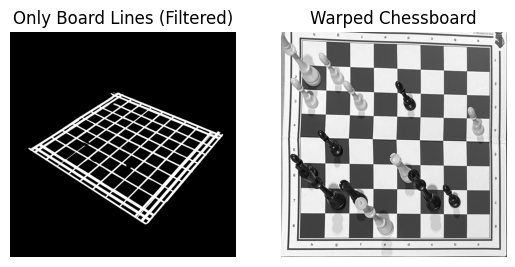

<Figure size 1500x700 with 0 Axes>

Processing G028_IMG101.jpg


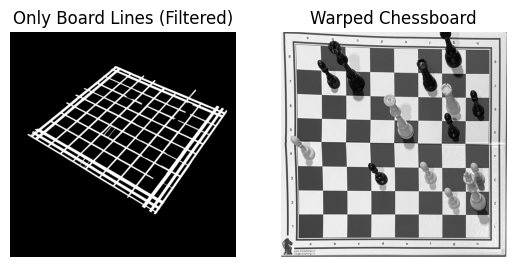

<Figure size 1500x700 with 0 Axes>

Processing G033_IMG043.jpg


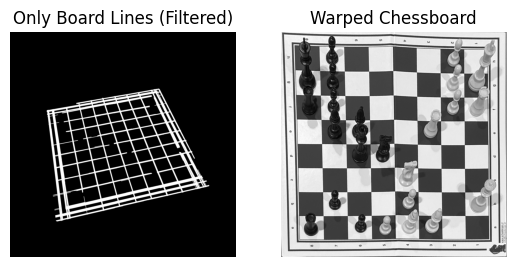

<Figure size 1500x700 with 0 Axes>

Processing G033_IMG075.jpg


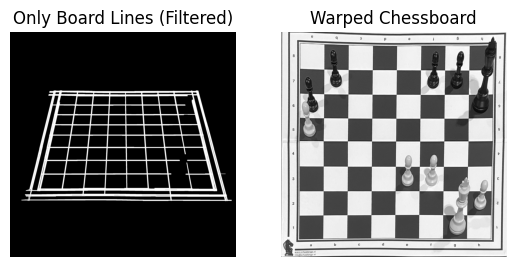

<Figure size 1500x700 with 0 Axes>

Processing G033_IMG088.jpg


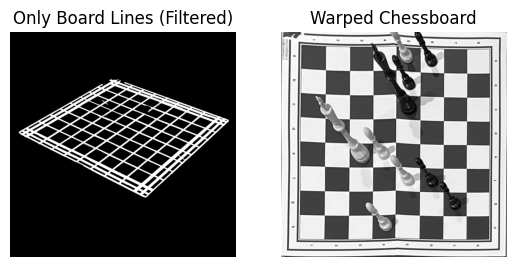

<Figure size 1500x700 with 0 Axes>

Processing G033_IMG101.jpg


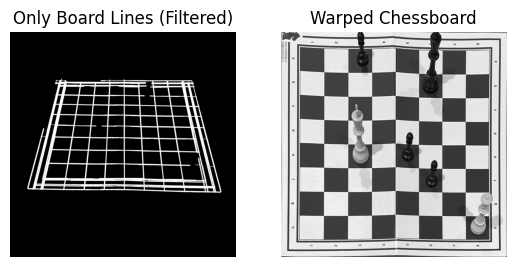

<Figure size 1500x700 with 0 Axes>

Processing G038_IMG074.jpg


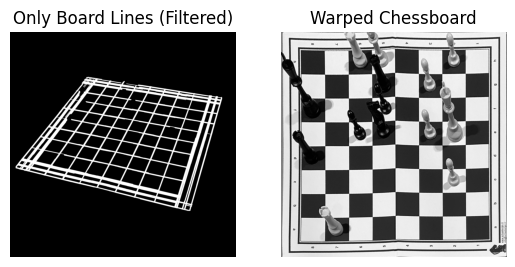

<Figure size 1500x700 with 0 Axes>

Processing G038_IMG088.jpg


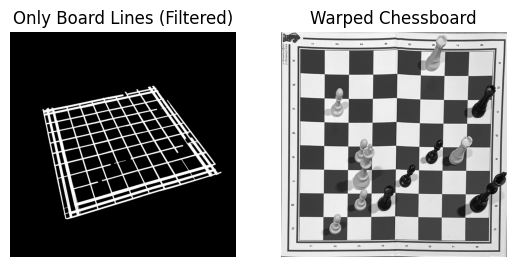

<Figure size 1500x700 with 0 Axes>

Processing G038_IMG103.jpg


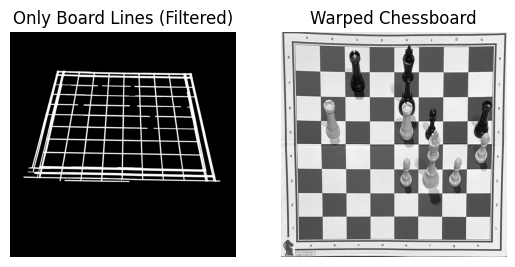

<Figure size 1500x700 with 0 Axes>

Processing G038_IMG105.jpg


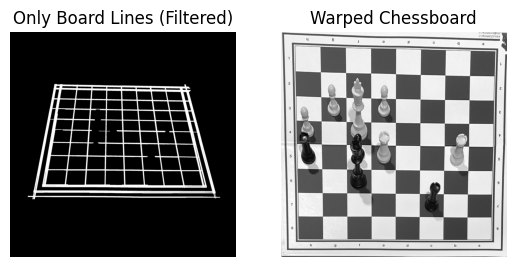

<Figure size 1500x700 with 0 Axes>

Processing G041_IMG042.jpg


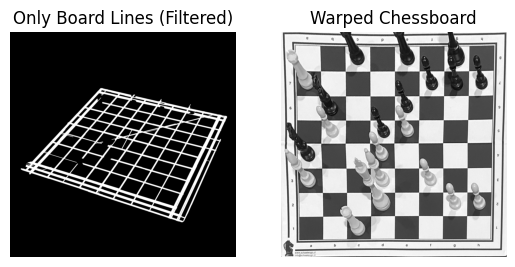

<Figure size 1500x700 with 0 Axes>

Processing G041_IMG048.jpg


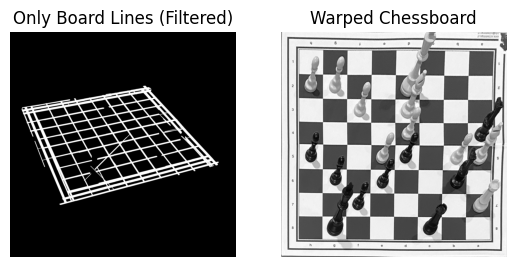

<Figure size 1500x700 with 0 Axes>

Processing G041_IMG088.jpg


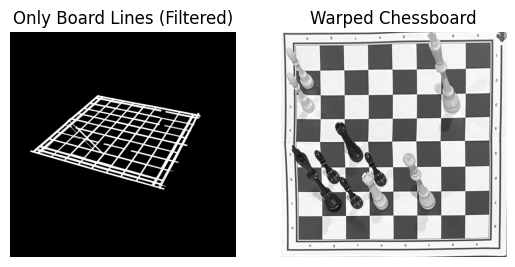

<Figure size 1500x700 with 0 Axes>

Processing G041_IMG098.jpg


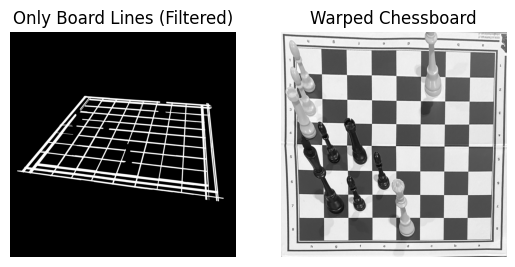

<Figure size 1500x700 with 0 Axes>

Processing G047_IMG053.jpg


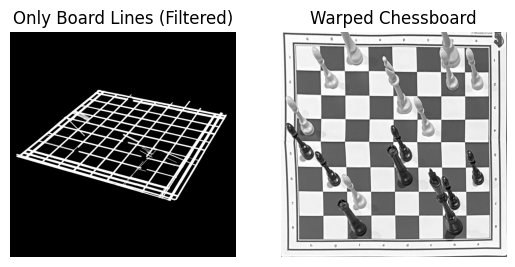

<Figure size 1500x700 with 0 Axes>

Processing G047_IMG068.jpg


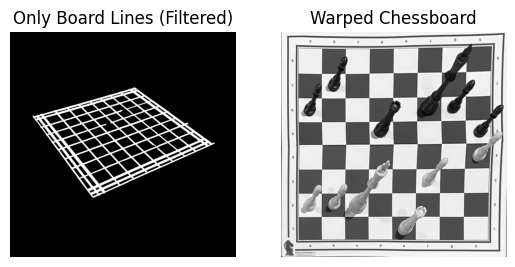

<Figure size 1500x700 with 0 Axes>

Processing G047_IMG102.jpg


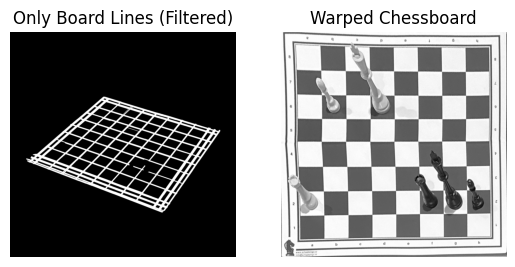

<Figure size 1500x700 with 0 Axes>

Processing G047_IMG107.jpg


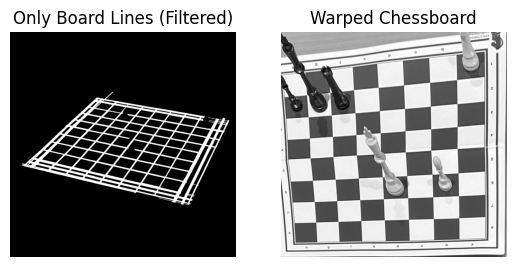

<Figure size 1500x700 with 0 Axes>

Processing G056_IMG017.jpg


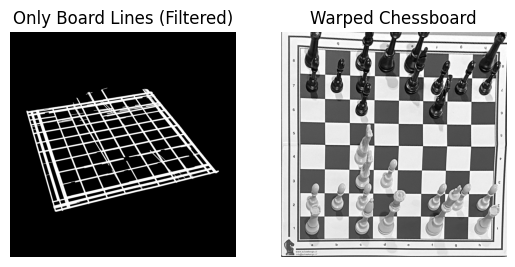

<Figure size 1500x700 with 0 Axes>

Processing G056_IMG077.jpg


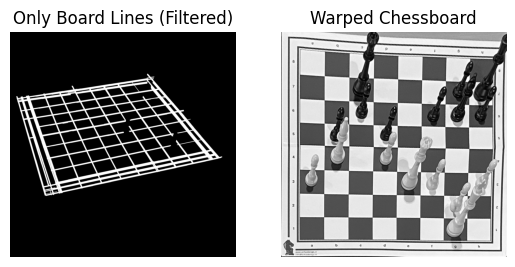

<Figure size 1500x700 with 0 Axes>

Processing G056_IMG097.jpg


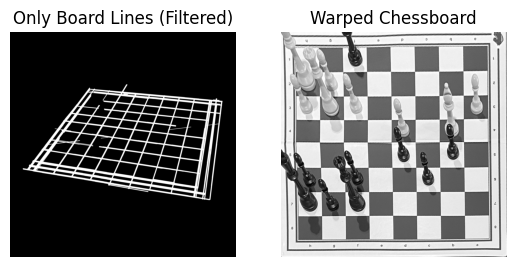

<Figure size 1500x700 with 0 Axes>

Processing G058_IMG044.jpg


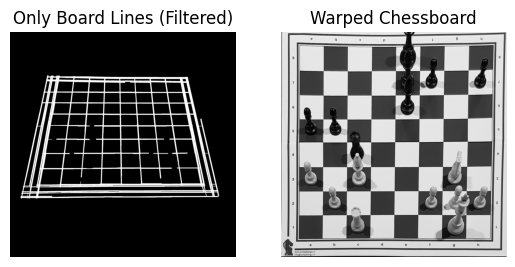

<Figure size 1500x700 with 0 Axes>

Processing G058_IMG074.jpg


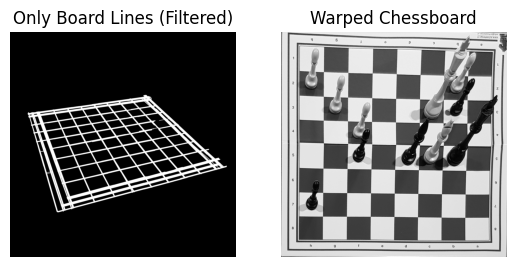

<Figure size 1500x700 with 0 Axes>

Processing G058_IMG100.jpg


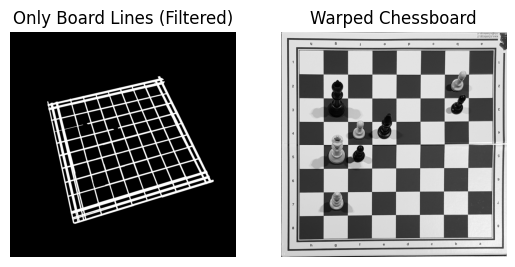

<Figure size 1500x700 with 0 Axes>

Processing G061_IMG080.jpg


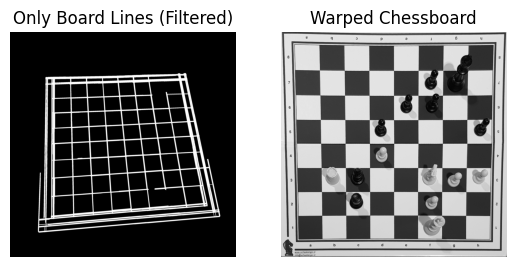

<Figure size 1500x700 with 0 Axes>

Processing G061_IMG092.jpg


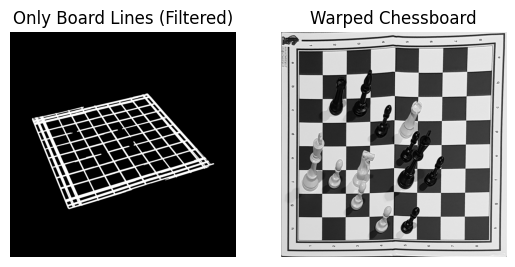

<Figure size 1500x700 with 0 Axes>

Processing G061_IMG098.jpg


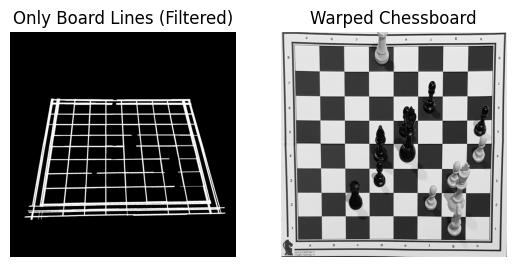

<Figure size 1500x700 with 0 Axes>

Processing G072_IMG083.jpg


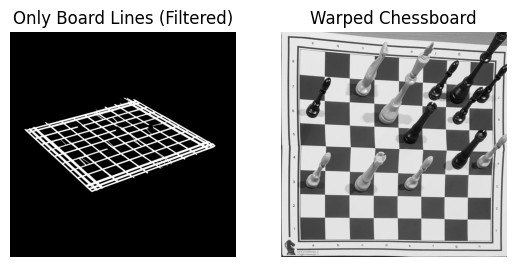

<Figure size 1500x700 with 0 Axes>

Processing G072_IMG098.jpg


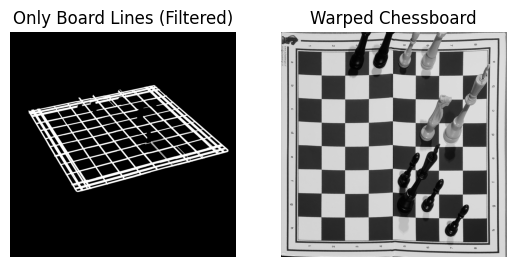

<Figure size 1500x700 with 0 Axes>

Processing G076_IMG072.jpg


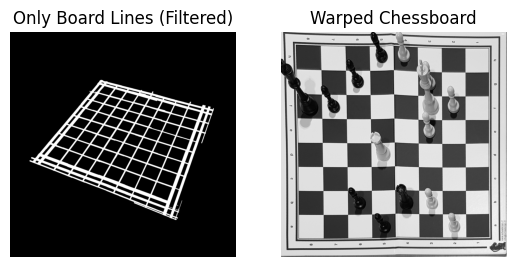

<Figure size 1500x700 with 0 Axes>

Processing G076_IMG089.jpg


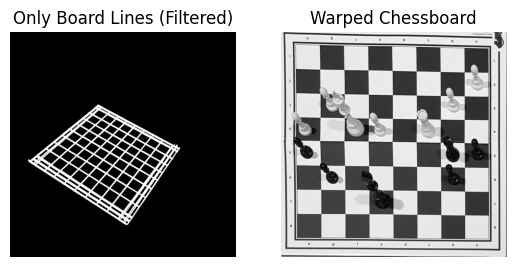

<Figure size 1500x700 with 0 Axes>

Processing G076_IMG095.jpg


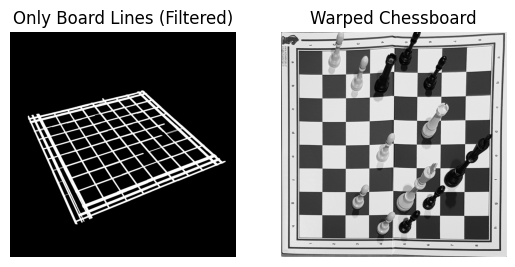

<Figure size 1500x700 with 0 Axes>

Processing G078_IMG092.jpg


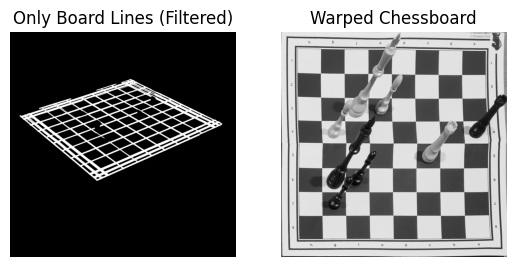

<Figure size 1500x700 with 0 Axes>

Processing G083_IMG073.jpg


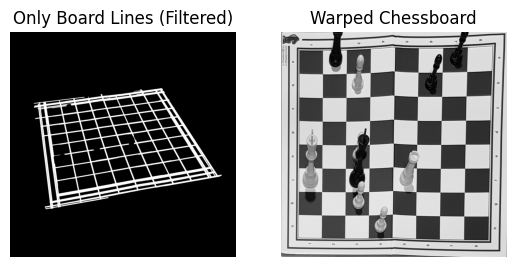

<Figure size 1500x700 with 0 Axes>

Processing G083_IMG089.jpg


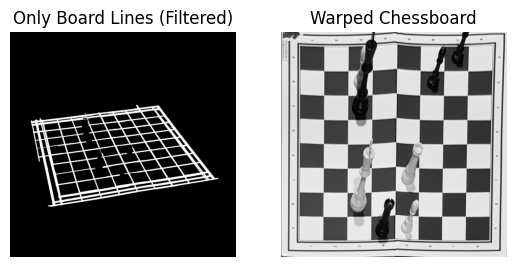

<Figure size 1500x700 with 0 Axes>

Processing G087_IMG093.jpg


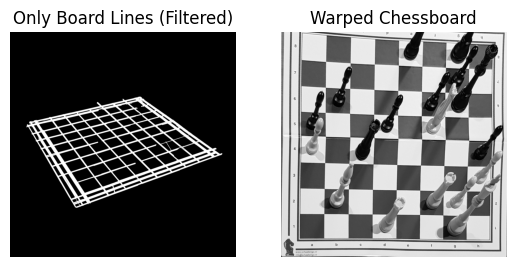

<Figure size 1500x700 with 0 Axes>

Processing G087_IMG099.jpg


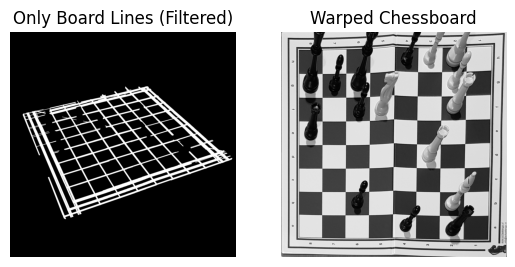

<Figure size 1500x700 with 0 Axes>

Processing G091_IMG053.jpg


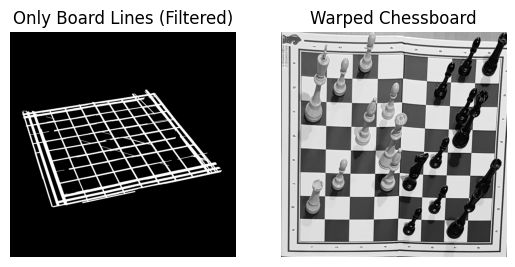

<Figure size 1500x700 with 0 Axes>

Processing G091_IMG074.jpg


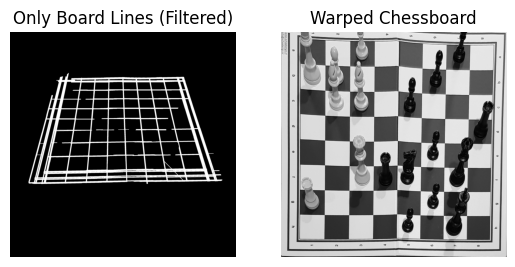

<Figure size 1500x700 with 0 Axes>

Processing G091_IMG102.jpg


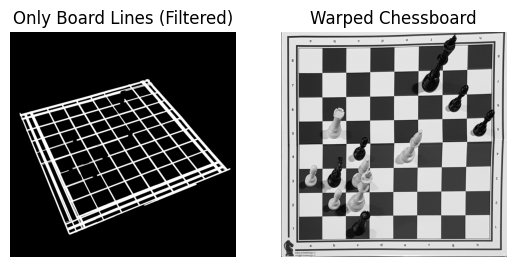

<Figure size 1500x700 with 0 Axes>

Processing G099_IMG094.jpg


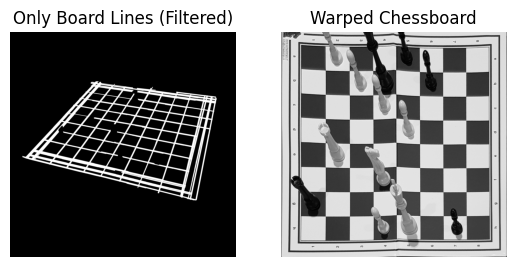

<Figure size 1500x700 with 0 Axes>


Images where chessboard detection failed:


In [11]:
# Process all images in the images folder
image_files = [os.path.join(BASE_IMG_FOLDER, f) for f in os.listdir(BASE_IMG_FOLDER) if f.endswith(('.jpg', '.png', '.jpeg'))]

# # Define specific image files to process
# image_filenames_failed = [
# "G058_IMG044.jpg",
# "G087_IMG099.jpg"
# ]

# # Create full paths for each image file
# image_files = [os.path.join(BASE_IMG_FOLDER, filename) for filename in image_filenames_failed]

# Process each image
failed_images = []
for image_path in image_files:
    print(f"Processing {os.path.basename(image_path)}")
    warped = process_chessboard_image(image_path)
    if (SHOW_DEBUG_IMGS != "NONE"):
        plt.figure(figsize=(15, 7))
        plt.tight_layout()
        plt.show()

    if warped is None:
        failed_images.append(os.path.basename(image_path))

print("\nImages where chessboard detection failed:")
for failed_image in failed_images:
    print(failed_image)